## 1. Setup Environment

In [1]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA RTX A6000
GPU Memory: 51.04 GB


In [2]:
%cd ..

/DATA/LLMM/Music-Classification-by-Spectogram


In [3]:
# Install dependencies
!pip install -r requirements.txt


/bin/bash: /apps/compilers/anaconda3-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Split data into train/validation sets
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
from tqdm import tqdm

def create_train_val_split(source_dir, train_dir, val_dir, val_split=0.2, seed=42):
    """
    Split spectrograms into train and validation sets
    """
    source_path = Path(source_dir)
    train_path = Path(train_dir)
    val_path = Path(val_dir)
    
    # Create directories
    train_path.mkdir(parents=True, exist_ok=True)
    val_path.mkdir(parents=True, exist_ok=True)
    
    # Get all spectrogram files
    all_files = list(source_path.rglob('*.png'))
    
    # Split
    train_files, val_files = train_test_split(
        all_files, test_size=val_split, random_state=seed
    )
    
    print(f"Copying {len(train_files)} files to train...")
    for file in tqdm(train_files):
        rel_path = file.relative_to(source_path)
        dest = train_path / rel_path
        dest.parent.mkdir(parents=True, exist_ok=True)
        if not dest.exists():
            shutil.copy2(file, dest)
    
    print(f"Copying {len(val_files)} files to validation...")
    for file in tqdm(val_files):
        rel_path = file.relative_to(source_path)
        dest = val_path / rel_path
        dest.parent.mkdir(parents=True, exist_ok=True)
        if not dest.exists():
            shutil.copy2(file, dest)
    
    return len(train_files), len(val_files)

# Create split
source_dir = 'AudioToSpectogram/output_mel'
train_dir = 'data/train'
val_dir = 'data/val'

# Check if split already exists
if Path(train_dir).exists() and Path(val_dir).exists():
    train_count = len(list(Path(train_dir).rglob('*.png')))
    val_count = len(list(Path(val_dir).rglob('*.png')))
    print(f"Train/val split already exists: {train_count} train, {val_count} val")
else:
    train_count, val_count = create_train_val_split(source_dir, train_dir, val_dir, val_split=0.2)
    print(f"\nSplit complete: {train_count} train, {val_count} val")

Copying 6397 files to train...


100%|██████████████████████████████████████████████| 6397/6397 [00:01<00:00, 4169.74it/s]


Copying 1600 files to validation...


100%|██████████████████████████████████████████████| 1600/1600 [00:00<00:00, 4120.06it/s]


Split complete: 6397 train, 1600 val


## 3. Configuration

In [5]:
# Load configuration files
import yaml
from pathlib import Path

def load_config(config_path):
    """Load YAML configuration file"""
    with open(config_path, 'r') as f:
        return yaml.safe_load(f)

# Load all configs
model_config = load_config('configs/model_config.yaml')
training_config = load_config('configs/training_config.yaml')
data_config = load_config('configs/data_config.yaml')

# Merge configs
config = {**model_config, **training_config, **data_config}

print("Configuration loaded successfully!")
print(f"\nModel: {config['model']['name']}")
print(f"Embedding dimension: {config['model']['projection_head']['embedding_dim']}")
print(f"Batch size: {config['training']['batch_size']}")
print(f"Epochs: {config['training']['epochs']}")
print(f"Learning rate: {config['training']['optimizer']['learning_rate']}")

Configuration loaded successfully!

Model: AudioEncoderCNN
Embedding dimension: 256
Batch size: 32
Epochs: 100
Learning rate: 0.001


In [6]:
# Update data paths for Colab
config['data']['train_dir'] = 'data/train'
config['data']['val_dir'] = 'data/val'

# Adjust batch size for Colab GPU memory (if needed)
# Reduce if you encounter OOM errors
config['training']['batch_size'] = 32

# Adjust number of workers for Colab
config['training']['num_workers'] = 2

print("Configuration updated for Colab environment")

Configuration updated for Colab environment


## 4. Model Setup

In [6]:
# Import model components
import sys
sys.path.append('CNN')

from CNN.models import build_model
from CNN.augmentation import get_augmentation_pipeline
from CNN.data import create_dataloaders
from CNN.training import get_contrastive_loss
from CNN.utils.metrics import AverageMeter

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Build model
print("\nBuilding model...")
model = build_model(config)
model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1e6:.2f} MB (float32)")

Using device: cuda

Building model...

Model Summary:
Total parameters: 1,947,904
Trainable parameters: 1,947,904
Model size: 7.79 MB (float32)


## 5. Data Loading

In [7]:
# Create augmentation pipelines
train_transform = get_augmentation_pipeline(config, training=True)
val_transform = get_augmentation_pipeline(config, training=False)

# Create dataloaders
print("Creating dataloaders...")
train_loader, val_loader = create_dataloaders(config, train_transform, val_transform)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples: {len(val_loader.dataset)}")

Creating dataloaders...
Found 7997 spectrograms in AudioToSpectogram/output_mel
Found 7997 spectrograms in AudioToSpectogram/output_mel
Train batches: 199
Val batches: 50
Train samples: 6397
Val samples: 1600


Visualizing augmented pairs...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5508533..3.0971894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.625031].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7290012..0.37727264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9735682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9942157..3.0395403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2538779..3.067812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2

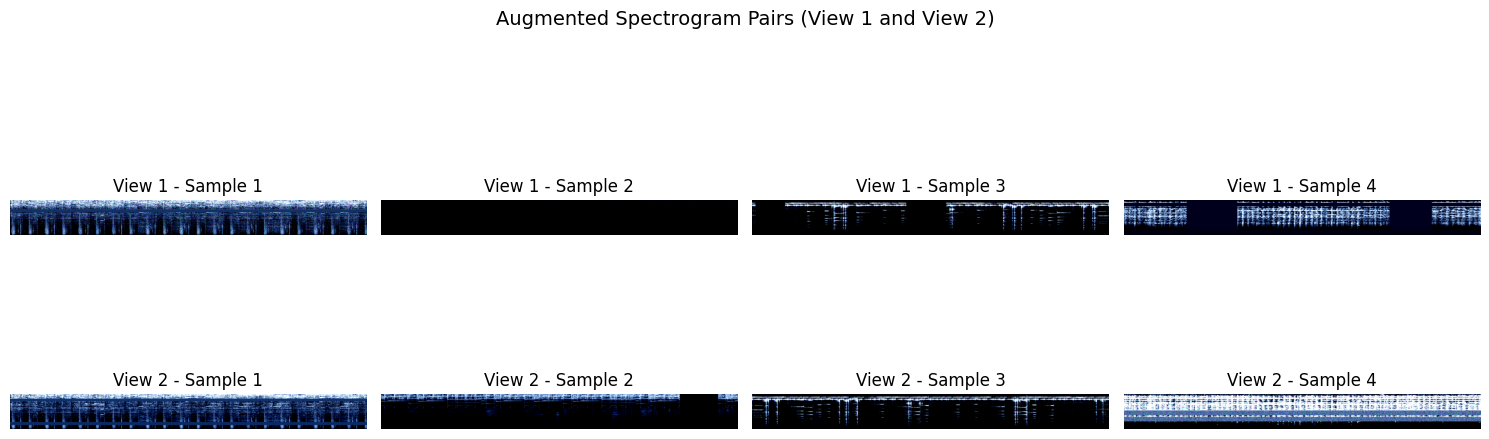

In [8]:
# Visualize a batch of spectrograms
import matplotlib.pyplot as plt
import numpy as np

def visualize_batch(loader, num_samples=4):
    """
    Visualize augmented spectrogram pairs
    """
    view1, view2 = next(iter(loader))
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('Augmented Spectrogram Pairs (View 1 and View 2)', fontsize=14)
    
    for i in range(num_samples):
        # View 1
        img1 = view1[i].cpu().numpy().transpose(1, 2, 0)
        axes[0, i].imshow(img1)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'View 1 - Sample {i+1}')
        
        # View 2
        img2 = view2[i].cpu().numpy().transpose(1, 2, 0)
        axes[1, i].imshow(img2)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'View 2 - Sample {i+1}')
    
    plt.tight_layout()
    plt.show()

print("Visualizing augmented pairs...")
visualize_batch(train_loader, num_samples=4)

## 6. Training Setup

In [9]:
import torch.optim as optim
from pathlib import Path

# Create loss function
contrastive_config = training_config['training']['contrastive']
criterion = get_contrastive_loss(
    loss_type=contrastive_config['loss_type'],
    temperature=contrastive_config['temperature'],
    use_cosine_similarity=contrastive_config['use_cosine_similarity']
)

# Create optimizer
optimizer_config = training_config['training']['optimizer']
optimizer = optim.Adam(
    model.parameters(),
    lr=optimizer_config['learning_rate'],
    weight_decay=optimizer_config['weight_decay']
)

# Create learning rate scheduler
scheduler_config = training_config['training']['scheduler']
if scheduler_config['type'] == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=training_config['training']['epochs'],
        eta_min=scheduler_config['min_lr']
    )

# Create checkpoint directory
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print("Training setup complete!")
print(f"Optimizer: {optimizer_config['type']}")
print(f"Learning rate: {optimizer_config['learning_rate']}")
print(f"Loss function: {contrastive_config['loss_type']}")
print(f"Temperature: {contrastive_config['temperature']}")

Training setup complete!
Optimizer: adam
Learning rate: 0.001
Loss function: nt_xent
Temperature: 0.5


In [10]:
# Setup TensorBoard
%load_ext tensorboard

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Create log directory with timestamp
log_dir = Path('runs') / datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir.mkdir(parents=True, exist_ok=True)
writer = SummaryWriter(log_dir)

print(f"TensorBoard log directory: {log_dir}")
print("Launch TensorBoard with: %tensorboard --logdir runs")

2025-11-14 17:25:29.008825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 17:25:29.058917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorBoard log directory: runs/20251114_172530
Launch TensorBoard with: %tensorboard --logdir runs


2025-11-14 17:25:30.496714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 7. Training Loop

In [11]:
# Training functions
from tqdm.notebook import tqdm

def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """
    Train for one epoch
    """
    model.train()
    losses = AverageMeter()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (view1, view2) in enumerate(pbar):
        view1 = view1.to(device)
        view2 = view2.to(device)
        
        # Forward pass for both views
        z1 = model(view1)
        z2 = model(view2)
        
        # Compute loss
        loss = criterion(z1, z2)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update metrics
        losses.update(loss.item(), view1.size(0))
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{losses.avg:.4f}'})
    
    return losses.avg


def validate(model, val_loader, criterion, device):
    """
    Validate model
    """
    model.eval()
    losses = AverageMeter()
    
    with torch.no_grad():
        for view1, view2 in tqdm(val_loader, desc="Validation"):
            view1 = view1.to(device)
            view2 = view2.to(device)
            
            # Forward pass
            z1 = model(view1)
            z2 = model(view2)
            
            # Compute loss
            loss = criterion(z1, z2)
            losses.update(loss.item(), view1.size(0))
    
    return losses.avg

print("Training functions defined")

Training functions defined


In [12]:
# Main training loop
import time

print("Starting training...\n")
best_val_loss = float('inf')
epochs = training_config['training']['epochs']
train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(1, epochs + 1):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Step scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Log to tensorboard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('LR', current_lr, epoch)
    
    # Print epoch summary
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = checkpoint_dir / 'best_model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'config': config
        }, checkpoint_path)
        print(f"✓ Saved best model (val_loss: {val_loss:.4f})")
    
    # Save periodic checkpoint
    if epoch % 10 == 0:
        checkpoint_path = checkpoint_dir / f'checkpoint_epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'config': config
        }, checkpoint_path)
        print(f"✓ Saved checkpoint at epoch {epoch}")
    
    print(f"{'='*60}")

# Training complete
total_time = time.time() - start_time
print(f"\n{'='*60}")
print("Training completed!")
print(f"Total time: {total_time/3600:.2f} hours")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"{'='*60}")

writer.close()

Starting training...



Epoch 1:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/100
Train Loss: 3.5446 | Val Loss: 2.8729
Learning Rate: 0.001000
✓ Saved best model (val_loss: 2.8729)


Epoch 2:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2/100
Train Loss: 3.2092 | Val Loss: 2.7708
Learning Rate: 0.000999
✓ Saved best model (val_loss: 2.7708)


Epoch 3:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3/100
Train Loss: 3.0900 | Val Loss: 2.7302
Learning Rate: 0.000998
✓ Saved best model (val_loss: 2.7302)


Epoch 4:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4/100
Train Loss: 3.0190 | Val Loss: 2.7172
Learning Rate: 0.000996
✓ Saved best model (val_loss: 2.7172)


Epoch 5:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5/100
Train Loss: 2.9824 | Val Loss: 2.7147
Learning Rate: 0.000994
✓ Saved best model (val_loss: 2.7147)


Epoch 6:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 6/100
Train Loss: 2.9533 | Val Loss: 2.6902
Learning Rate: 0.000991
✓ Saved best model (val_loss: 2.6902)


Epoch 7:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 7/100
Train Loss: 2.9289 | Val Loss: 2.6816
Learning Rate: 0.000988
✓ Saved best model (val_loss: 2.6816)


Epoch 8:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 8/100
Train Loss: 2.9017 | Val Loss: 2.6531
Learning Rate: 0.000984
✓ Saved best model (val_loss: 2.6531)


Epoch 9:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 9/100
Train Loss: 2.8896 | Val Loss: 2.6467
Learning Rate: 0.000980
✓ Saved best model (val_loss: 2.6467)


Epoch 10:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 10/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000976
✓ Saved checkpoint at epoch 10


Epoch 11:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 11/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000970


Epoch 12:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 12/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000965


Epoch 13:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 13/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000959


Epoch 14:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 14/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000952


Epoch 15:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 15/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000946


Epoch 16:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 16/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000938


Epoch 17:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 17/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000930


Epoch 18:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 18/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000922


Epoch 19:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 19/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000914


Epoch 20:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 20/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000905
✓ Saved checkpoint at epoch 20


Epoch 21:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 21/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000895


Epoch 22:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 22/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000885


Epoch 23:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 23/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000875


Epoch 24:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 24/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000865


Epoch 25:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 25/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000854


Epoch 26:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 26/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000842


Epoch 27:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 27/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000831


Epoch 28:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 28/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000819


Epoch 29:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 29/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000807


Epoch 30:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 30/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000794
✓ Saved checkpoint at epoch 30


Epoch 31:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 31/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000781


Epoch 32:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 32/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000768


Epoch 33:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 33/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000755


Epoch 34:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 34/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000741


Epoch 35:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 35/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000727


Epoch 36:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 36/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000713


Epoch 37:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 37/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000699


Epoch 38:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 38/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000684


Epoch 39:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 39/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000670


Epoch 40:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 40/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000655
✓ Saved checkpoint at epoch 40


Epoch 41:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 41/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000640


Epoch 42:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 42/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000625


Epoch 43:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 43/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000609


Epoch 44:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 44/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000594


Epoch 45:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 45/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000579


Epoch 46:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 46/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000563


Epoch 47:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 47/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000548


Epoch 48:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 48/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000532


Epoch 49:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 49/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000516


Epoch 50:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 50/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000501
✓ Saved checkpoint at epoch 50


Epoch 51:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 51/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000485


Epoch 52:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 52/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000469


Epoch 53:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 53/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000453


Epoch 54:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 54/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000438


Epoch 55:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 55/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000422


Epoch 56:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 56/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000407


Epoch 57:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 57/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000392


Epoch 58:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 58/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000376


Epoch 59:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 59/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000361


Epoch 60:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 60/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000346
✓ Saved checkpoint at epoch 60


Epoch 61:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 61/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000331


Epoch 62:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 62/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000317


Epoch 63:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 63/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000302


Epoch 64:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 64/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000288


Epoch 65:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 65/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000274


Epoch 66:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 66/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000260


Epoch 67:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 67/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000246


Epoch 68:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 68/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000233


Epoch 69:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 69/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000220


Epoch 70:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 70/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000207
✓ Saved checkpoint at epoch 70


Epoch 71:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 71/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000194


Epoch 72:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 72/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000182


Epoch 73:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 73/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000170


Epoch 74:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 74/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000159


Epoch 75:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 75/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000147


Epoch 76:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 76/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000136


Epoch 77:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 77/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000126


Epoch 78:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 78/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000116


Epoch 79:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 79/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000106


Epoch 80:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 80/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000096
✓ Saved checkpoint at epoch 80


Epoch 81:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 81/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000087


Epoch 82:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 82/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000079


Epoch 83:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 83/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000071


Epoch 84:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 84/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000063


Epoch 85:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 85/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000055


Epoch 86:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 86/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000049


Epoch 87:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 87/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000042


Epoch 88:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 88/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000036


Epoch 89:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 89/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000031


Epoch 90:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 90/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000025
✓ Saved checkpoint at epoch 90


Epoch 91:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 91/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000021


Epoch 92:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 92/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000017


Epoch 93:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 93/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000013


Epoch 94:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 94/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000010


Epoch 95:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 95/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000007


Epoch 96:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 96/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000005


Epoch 97:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 97/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000003


Epoch 98:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 98/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000002


Epoch 99:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 99/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000001


Epoch 100:   0%|          | 0/199 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 100/100
Train Loss: nan | Val Loss: nan
Learning Rate: 0.000001
✓ Saved checkpoint at epoch 100

Training completed!
Total time: 2.23 hours
Best validation loss: 2.6467


## 8. Training Visualization

In [ ]:
# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss difference
plt.subplot(1, 2, 2)
loss_diff = [v - t for t, v in zip(train_losses, val_losses)]
plt.plot(loss_diff, label='Val - Train', linewidth=2, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.title('Overfitting Monitor')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final val loss: {val_losses[-1]:.4f}")
print(f"Best val loss: {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses))+1})")

In [ ]:
# Launch TensorBoard
%tensorboard --logdir runs

## 9. Model Evaluation

In [ ]:
# Load best model
checkpoint_path = checkpoint_dir / 'best_model.pth'
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")

In [ ]:
# Extract embeddings for a few samples
from CNN.embeddings import extract_embeddings

# Extract embeddings from validation set
print("Extracting embeddings...")
embeddings, file_paths = extract_embeddings(
    model=model,
    data_dir=config['data']['val_dir'],
    device=device,
    batch_size=64
)

print(f"\nExtracted embeddings shape: {embeddings.shape}")
print(f"Number of samples: {len(file_paths)}")

In [ ]:
# Visualize embeddings using t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=50)
plt.title('t-SNE Visualization of Learned Embeddings', fontsize=14)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)
plt.savefig('embeddings_tsne.png', dpi=150, bbox_inches='tight')
plt.show()

print("Embeddings visualization saved!")

## 11. Inference Example

In [ ]:
# Test inference on a single spectrogram
from PIL import Image
import torchvision.transforms as transforms

def predict_embedding(model, image_path, device):
    """
    Extract embedding for a single spectrogram
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Extract embedding
    model.eval()
    with torch.no_grad():
        embedding = model(image_tensor)
    
    return embedding.cpu().numpy()

# Test on a sample
sample_path = list(Path(config['data']['val_dir']).rglob('*.png'))[0]
embedding = predict_embedding(model, sample_path, device)

print(f"Sample: {sample_path.name}")
print(f"Embedding shape: {embedding.shape}")
print(f"Embedding (first 10 values): {embedding[0, :10]}")

## 12. Summary

### Files Generated:
- `checkpoints/best_model.pth` - Best model checkpoint
- `exported_models/music_encoder.pth` - Exported model for inference
- `training_curves.png` - Training visualization
- `embeddings_tsne.png` - Embedding visualization

### To use this model:
```python
# Load model
checkpoint = torch.load('exported_models/music_encoder.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Extract embeddings
embedding = model(spectrogram_tensor)
```